<a href="https://colab.research.google.com/github/MehtiyevaNarmina/Image_Classification_using_CNN_in_PyTorch/blob/main/CNN_(PyTorch).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
import torch

In [6]:
train_on_gpu = torch.cuda.is_available()
if not train_on_gpu:
    print('CUDA is not available. Training on CPU')
else:
    print('CUDA is available. Training in GPU')


CUDA is not available. Training on CPU


In [7]:
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib as mpl
import torch
import torch.nn as nn
import torch.nn.functional as f
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler

import torchvision
import torchvision.datasets
import torchvision.utils as utils
import torchvision.transforms as transforms
import torchvision.datasets as datasets

import warnings
warnings.filterwarnings(action = 'ignore')

mpl.rcParams['figure.figsize'] = [16, 9]


In [8]:
num_workers = 0
batch_size = 20

valid_size = 0.2

transforms = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))]) #normalization(standart scaller)

train_data = datasets.CIFAR10('data', train = True, transform = transforms, download = True)
test_data = datasets.CIFAR10('data', train = False, transform = transforms, download = True)

Files already downloaded and verified
Files already downloaded and verified


In [9]:
num_train = len(train_data)
indicies = list(range(num_train))
np.random.shuffle(indicies)
split = int(np.floor(0.2 * num_train))
train_idx, valid_idx = indicies[split:], indicies[:split]

train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

In [10]:
# prepare data loaders (combine dataset and sampler)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
    sampler=train_sampler, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
    sampler=valid_sampler, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size,
    num_workers=num_workers)

In [11]:
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck']

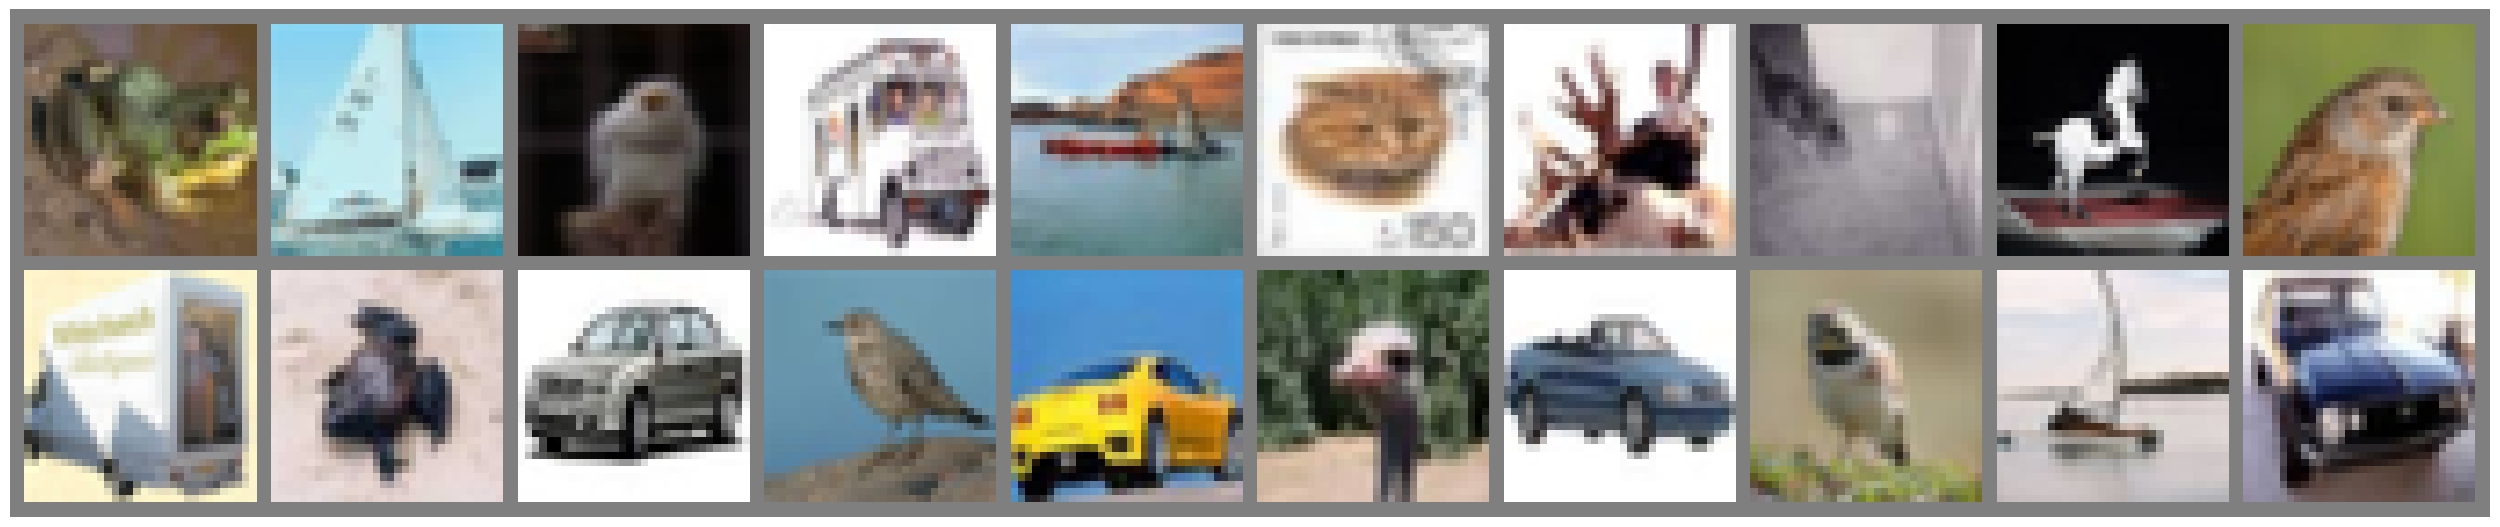

In [12]:
def imshow(image):
  if isinstance(image, torch.Tensor):
    image = image.numpy().transpose((1,2,0))
  else:
    image = np.array(image).transpose((1,2,0))

  mean = np.array([0.5, 0.5, 0.5])
  std = np.array([0.5, 0.5, 0.5])
  image = std * image + mean
  image = np.clip(image, 0, 1)
  fig, ax = plt.subplots(1,1, figsize = (32,32))

  plt.imshow(image)
  ax.axis('off')

images, _ = next(iter(train_loader))
out = torchvision.utils.make_grid(images, nrow=10)
imshow(out)



In [13]:
for images,labels in train_loader:
  print(images.shape)
  break

torch.Size([20, 3, 32, 32])


In [14]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # convolutional layer
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1) #(in_chanels, out_chanels, kernel_size)
        self.conv2 = nn.Conv2d(16, 32, 3, padding = 1)
        self.conv3 = nn.Conv2d(32, 16, 3, padding = 1)
        # max pooling layer
        self.pool = nn.MaxPool2d(2, 2)

        # Fully connected layer
        self.fc1 = nn.Linear(16 * 4 * 4, 10)

        # Dropout
        self.dropout = nn.Dropout(p=0.2)

        # Output layer
        self.out = nn.LogSoftmax(dim = 1)

    def flatten(self, x):
        return x.view(x.size()[0], -1)

    def forward(self, x):
        # add sequence of convolutional and max pooling layers
        x = self.dropout(self.pool(F.relu(self.conv1(x))))
        x = self.dropout(self.pool(F.relu(self.conv2(x))))
        x = self.dropout(self.pool(F.relu(self.conv3(x))))
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.out(x)
        return x
model = Net()
model

Net(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=256, out_features=10, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (out): LogSoftmax(dim=1)
)

In [15]:
if train_on_gpu:
    model.cuda()

In [16]:
criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(model.parameters(), lr = 0.01)

In [17]:
import numpy as np
n_epochs = 10

valid_loss_min = np.Inf # track change in validation loss

for epoch in range(1, n_epochs+1):

    # training and validation loss
    train_loss = 0.0
    valid_loss = 0.0

    #Train the model
    model.train()
    for data, target in train_loader:

        if train_on_gpu:
            data, target = data.cuda(), target.cuda()

        optimizer.zero_grad()

        output = model(data)

        loss = criterion(output, target)

        loss.backward()

        optimizer.step()

        train_loss += loss.item()*data.size(0)

        #Validate the model
    model.eval()
    for data, target in valid_loader:
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        output = model(data)
        loss = criterion(output, target)
        valid_loss += loss.item()*data.size(0)

    # calculate average losses
    train_loss = train_loss/len(train_loader.sampler)
    valid_loss = valid_loss/len(valid_loader.sampler)

    # print training/validation statistics
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss, valid_loss))

    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'model_cifar.pt')
        valid_loss_min = valid_loss

Epoch: 1 	Training Loss: 2.018666 	Validation Loss: 1.690065
Validation loss decreased (inf --> 1.690065).  Saving model ...
Epoch: 2 	Training Loss: 1.618796 	Validation Loss: 1.468041
Validation loss decreased (1.690065 --> 1.468041).  Saving model ...
Epoch: 3 	Training Loss: 1.486836 	Validation Loss: 1.381249
Validation loss decreased (1.468041 --> 1.381249).  Saving model ...
Epoch: 4 	Training Loss: 1.415765 	Validation Loss: 1.314709
Validation loss decreased (1.381249 --> 1.314709).  Saving model ...
Epoch: 5 	Training Loss: 1.360260 	Validation Loss: 1.255222
Validation loss decreased (1.314709 --> 1.255222).  Saving model ...
Epoch: 6 	Training Loss: 1.315374 	Validation Loss: 1.212631
Validation loss decreased (1.255222 --> 1.212631).  Saving model ...
Epoch: 7 	Training Loss: 1.282253 	Validation Loss: 1.181824
Validation loss decreased (1.212631 --> 1.181824).  Saving model ...
Epoch: 8 	Training Loss: 1.241968 	Validation Loss: 1.141164
Validation loss decreased (1.18182